In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
from scipy.interpolate import interp1d

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})



The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D


In [2]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [4]:
def patch_and_error_prog_n_sim(grid, force_terms_collection, y=None, PD_cutoff=1, FES_cutoff=None, use_ST_ERR=True, use_VNORM=False):
    
    force_terms_collection = np.array(force_terms_collection, dtype=float)
    assert len(np.shape(force_terms_collection)) == 4, "force_terms_collection must be a 4D array with dimensions (n_sim, n_iter, 4_force_terms, nbins)"
    
    n_sim = np.shape(force_terms_collection)[0]
    n_iter = np.shape(force_terms_collection)[1]
    nbins = np.shape(force_terms_collection)[3]
    dx = grid[1] - grid[0]
    
    PD = np.zeros(nbins)
    PD2 = np.zeros(nbins)
    Force_num = np.zeros(nbins)
    ofv_num = np.zeros(nbins)
    
    ofe_prog = np.zeros(n_iter)
    aad_prog = np.zeros(n_iter)
    
    for i in range(n_iter):
        
        for j in range(n_sim):
            
            PD += force_terms_collection[j, i, 0, :]
            PD2 += force_terms_collection[j, i, 1, :]
            Force_num += force_terms_collection[j, i, 2, :] * force_terms_collection[j, i, 0, :]
            ofv_num += force_terms_collection[j, i, 3, :]
            
        Force = np.divide(Force_num, PD, out=np.zeros_like(Force_num), where=PD>1E-10)
        FES = lib1.intg_1D(Force, dx)
        
        # Find cutoff
        cutoff = np.where(FES > FES_cutoff, 0, 1) if FES_cutoff is not None else np.ones(nbins)
        if PD_cutoff is not None and PD_cutoff > 0: cutoff = np.where(PD < PD_cutoff, 0, cutoff)
        space_explored = np.sum(cutoff)      
        ratio_explored = space_explored / nbins

        # Find error of the mean force
        ofv = np.divide(ofv_num, PD, out=np.zeros_like(ofv_num), where=(PD>1E-10) & (cutoff > 0.5)) - np.square(Force)
        Bessel_corr_num = PD2.copy() if use_ST_ERR == True else np.square(PD)
        ofv *= np.divide(Bessel_corr_num, np.square(PD) - PD2, out=np.zeros_like(Bessel_corr_num), where=((np.square(PD) - PD2 > 0) & (cutoff > 0.5)))
        ofe = np.sqrt(ofv*cutoff)
        Aofe = np.sum(ofe) / space_explored if space_explored > 0 else np.nan
        if use_VNORM: Aofe = Aofe * space_explored / nbins
        
        if y is not None:
            AD = abs(FES - y) * cutoff
            AAD = np.sum(AD) / space_explored if space_explored > 0 else np.nan
            if use_VNORM: AAD = AAD * space_explored / nbins

        ofe_prog[i] = Aofe
        aad_prog[i] = AAD
            
    return ofe_prog, aad_prog
    

#### Long (single) simulation 

t=[1.00,100.00] | Final avr: AOFE=0.553, AAD=0.066


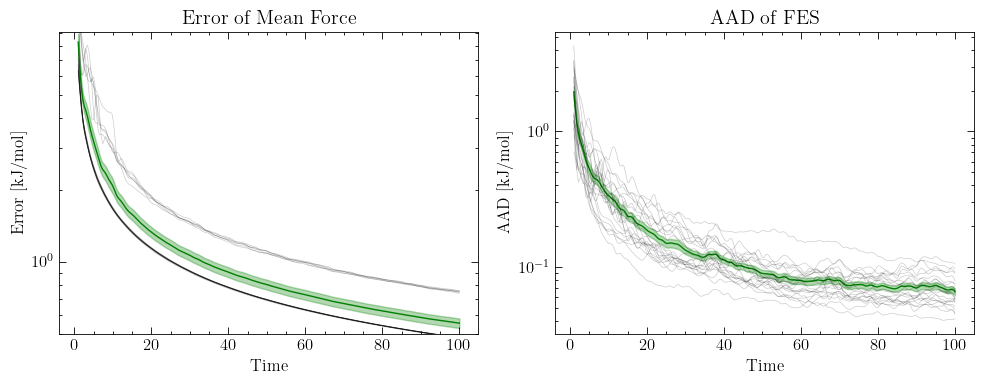

In [2]:
path_long = path_notebook + "/_data_long/"
n_surf = 3
total_campaigns = 22
time_budget = 100

avr_prog = lib1.get_avr_error_prog(path_long, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="long", show_plot=True, return_avr_prog=True)
t_long, ofe_mean_long, ofe_std_long, aad_mean_long, aad_std_long = avr_prog

lib1.save_pkl([t_long, ofe_mean_long, ofe_std_long, aad_mean_long, aad_std_long], path_notebook + f"/error_progressions/error_progression_long_S{n_surf}.pkl")


#### Parallel Simulations

In [9]:
# def patch_and_error_prog_n_sim(grid, force_terms_collection, y=None, PD_cutoff=1, FES_cutoff=None, use_ST_ERR=True, use_VNORM=False):
    
#     force_terms_collection = np.array(force_terms_collection, dtype=float)
#     assert len(np.shape(force_terms_collection)) == 4, "force_terms_collection must be a 4D array with dimensions (n_sim, n_iter, 4_force_terms, nbins)"
    
#     n_sim = np.shape(force_terms_collection)[0]
#     n_iter = np.shape(force_terms_collection)[1]
#     nbins = np.shape(force_terms_collection)[3]
#     dx = grid[1] - grid[0]
    
#     PD, PD2, Force_num, ofv_num  = np.zeros(nbins), np.zeros(nbins), np.zeros(nbins), np.zeros(nbins)
#     ofe_prog, aad_prog = np.zeros(n_iter), np.zeros(n_iter)
    
#     for i in range(n_iter):
#         for j in range(n_sim):
#             PD += force_terms_collection[j, i, 0, :]
#             PD2 += force_terms_collection[j, i, 1, :]
#             Force_num += force_terms_collection[j, i, 2, :] * force_terms_collection[j, i, 0, :]
#             ofv_num += force_terms_collection[j, i, 3, :]
            
#         Force = np.divide(Force_num, PD, out=np.zeros_like(Force_num), where=PD>1E-10)
#         FES = lib1.intg_1D(Force, dx)
        
#         # Find cutoff
#         cutoff = np.where(FES > FES_cutoff, 0, 1) if FES_cutoff is not None else np.ones(nbins)
#         if PD_cutoff is not None and PD_cutoff > 0: cutoff = np.where(PD < PD_cutoff, 0, cutoff)
#         space_explored = np.sum(cutoff)      
#         ratio_explored = space_explored / nbins

#         # Find error of the mean force
#         ofv = np.divide(ofv_num, PD, out=np.zeros_like(ofv_num), where=(PD>1E-10) & (cutoff > 0.5)) - np.square(Force)
#         Bessel_corr_num = PD2.copy() if use_ST_ERR == True else np.square(PD)
#         ofv *= np.divide(Bessel_corr_num, np.square(PD) - PD2, out=np.zeros_like(Bessel_corr_num), where=((np.square(PD) - PD2 > 0) & (cutoff > 0.5)))
#         ofe = np.sqrt(ofv*cutoff)
#         Aofe = np.sum(ofe) / space_explored if space_explored > 0 else np.nan
#         if use_VNORM: Aofe = Aofe * space_explored / nbins
        
#         if y is not None:
#             AD = abs(FES - y) * cutoff
#             AAD = np.sum(AD) / space_explored if space_explored > 0 else np.nan
#             if use_VNORM: AAD = AAD * space_explored / nbins
#         else: AAD = None

#         ofe_prog[i] = Aofe
#         aad_prog[i] = AAD
            
#     return ofe_prog, aad_prog
    
# for _old_code_ in [0]:
#     # force_terms_collection, time = [], []

#     # sim_index = [1,2,3,4]
#     # # sim_index = [7,13,23,69]
#     # # for ii in range(1,5):
#     # for ii in sim_index:
        
#     #     new_path = simulation_path + "simulation_" + str(ii) + "/"
#     #     os.chdir(new_path)
        
#     #     force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{ii}_20M.pkl")
#     #     force_terms_collection.append(forces_e_list)
#     #     time.append(np.array(Avr_Error_list)[:,0])
        
#     # ofe_prog, aad_prog = patch_and_error_prog_n_sim(grid, force_terms_collection, y=y, PD_cutoff=1, FES_cutoff=50, use_ST_ERR=True, use_VNORM=False)  
#     # time = np.sum(time, axis=0)

#     # print(f"AOFE: {ofe_prog[-1]},  AAD: {aad_prog[-1]}")

#     # plt.figure(figsize=(10,4))
#     # plt.subplot(1,2,1)
#     # plt.plot(time, ofe_prog, color="red", label=f"Patched Sim {sim_index}")
#     # plt.title("Progression of Error of the mean force"); plt.xlabel("Time [ns]"); plt.ylabel("Mean Force Error [kJ/mol]"); plt.yscale("log")

#     # plt.subplot(1,2,2)
#     # plt.plot(time, aad_prog, color="red", label=f"Patched Sim {sim_index}")
#     # plt.title("Progression of Avr. Abs. Deviation of the FES"); plt.xlabel("Time [ns]"); plt.ylabel("AAD [kJ/mol]"); plt.yscale("log")


#     # for ii in sim_index:
        
#     #     new_path = simulation_path + "simulation_" + str(ii) + "/"
#     #     os.chdir(new_path)
#     #     force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{ii}_20M.pkl")

#     #     plt.subplot(1,2,1)
#     #     plt.plot(np.array(Avr_Error_list)[:,0], np.array(Avr_Error_list)[:,2], label=f"Simulation {ii}", alpha=0.5, linewidth=0.5, color="black")
#     #     plt.subplot(1,2,2)
#     #     plt.plot(np.array(Avr_Error_list)[:,0], np.array(Avr_Error_list)[:,4], label=f"Simulation {ii}", alpha=0.5, linewidth=0.5, color="black")


#     # plt.legend()
#     # plt.tight_layout(); plt.show()
#     pass


In [17]:

# for n_surf in range(20):
#     if n_surf == 3: continue
#     for i in range(1,15):
        
#         path_folder = path_long + f"S{n_surf}/simulation_{i}_10ns/"
        
#         os.rename(path_folder + f"error_progression_{i}_10ns.pkl", path_folder + f"error_progression_{i}_100ns.pkl")
#         os.rename(path_folder + f"HILLS_{i}_10ns", path_folder + f"HILLS_{i}_100ns")
#         os.rename(path_folder + f"position_{i}_10ns", path_folder + f"position_{i}_100ns")
#         os.rename(path_folder + f"MFI_results_{i}_10ns.pkl", path_folder + f"MFI_results_{i}_100ns.pkl")
        
#         os.rename(path_folder, path_long + f"S{n_surf}/simulation_{i}_100ns/")
        
        

Simulation 1, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_1/, file: MFI_data1_20M.pkl
Simulation 2, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_2/, file: MFI_data2_20M.pkl
Simulation 3, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_3/, file: MFI_data3_20M.pkl
Simulation 4, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_4/, file: MFI_data4_20M.pkl
Simulation 5, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_5/, file: MFI_data5_20M.pkl
Simulation 6, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_6/, file: MFI_data6_20M.pkl
Simulation 7, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_7/, file: MFI_data7_20M.pkl
Simulation 8, path: /home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/simulation_8/, file: MFI_data8_20M.pkl
Simulation 9, path: /home/ucecab

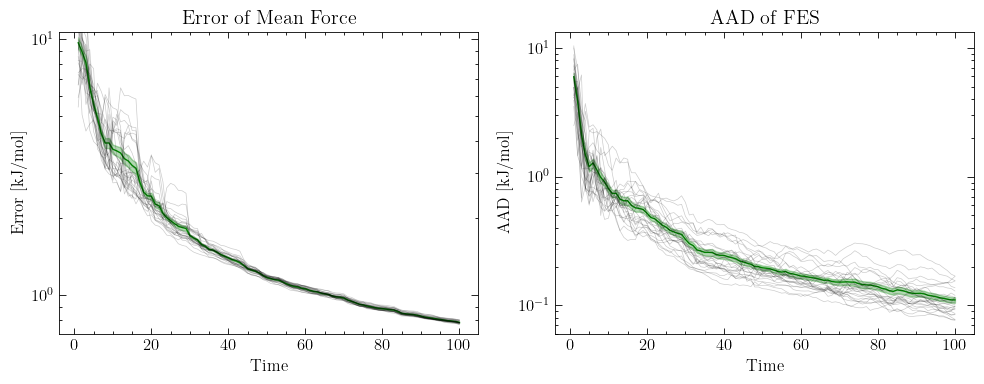

AOFE: 0.7848667356676771,  AAD: 0.11042079120012473


In [24]:
# simulation_path = "/home/ucecabj/Desktop/MFI_Antoniu/MFI_class/simulation_longx4/"
# os.chdir(simulation_path)

# use_VNORM = True

# err_collection = []
# aad_collection = []

# for i in range(25):
       
#     force_terms_collection, time = [], []
#     for ii in range(i*4 + 1, (i+1)*4+1):
        
#         new_path = simulation_path + "simulation_" + str(ii) + "/"
#         os.chdir(new_path)
                
#         force_terms, Avr_Error_list, Maps_list, forces_e_list = lib1.load_pkl(f"MFI_data{ii}_20M_25ns.pkl")
#         force_terms_collection.append(forces_e_list)
#         time.append(np.array(Avr_Error_list)[:,0])
        
#     # ofe_prog, aad_prog = patch_and_error_prog_n_sim(grid, force_terms_collection, y=y, PD_cutoff=1, FES_cutoff=50, use_ST_ERR=True, use_VNORM=use_VNORM)  
#     ofe_prog, aad_prog = lib1.patch_and_error_prog_parallel_sim(grid, force_terms_collection, y=y, PD_cutoff=1, FES_cutoff=50, use_ST_ERR=True, use_VNORM=use_VNORM)  
#     err_collection.append(ofe_prog)
#     aad_collection.append(aad_prog)
#     time = np.sum(time, axis=0)
    

# [time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p] = lib1.get_mean_ste_of_n_error_prog(time, err_collection, aad_collection, plot=False, plot_log=True, plot_title=["Error of Mean Force", "AAD of FES"], plot_xlabel=["Time"], plot_ylabel=["Error [kJ/mol]","AAD [kJ/mol]"])


# for i in range(len(err_collection)):         
#     plt.subplot(1,2,1)
#     plt.plot(time, err_collection[i], linewidth=0.5, alpha=0.2, color="black")
#     plt.subplot(1,2,2)
#     plt.plot(time, aad_collection[i], linewidth=0.5, alpha=0.2, color="black")    
    
# plt.tight_layout(); plt.show()
# print(f"AOFE: {ofe_mean_p[-1]},  AAD: {aad_mean_p[-1]}")


#### Single simulation with RTR (serial simulations)

t=[0.55,100.01] | Final avr: AOFE=0.472, AAD=0.052


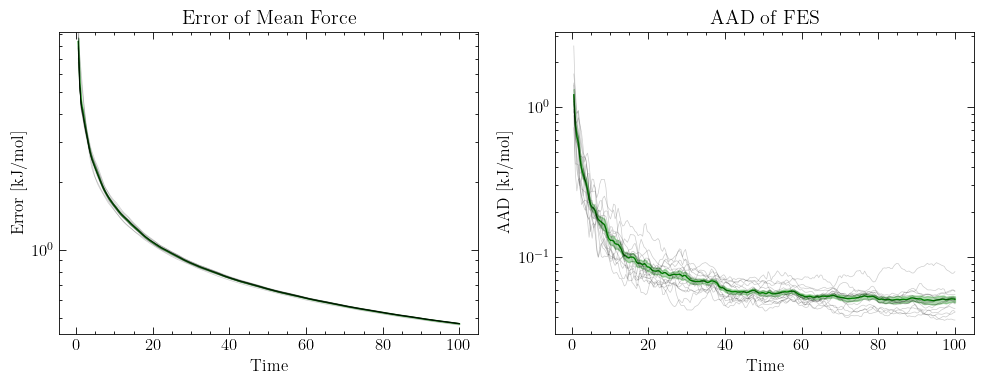

In [3]:
path_SRTR = path_notebook + "/_data_SRTR/"
n_surf = 3
total_campaigns = 15
time_budget = 100

# calculate and plot the average error progression
avr_prog = lib1.get_avr_error_prog(path_SRTR, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="SRTR", show_plot=True, return_avr_prog=True)
time_SRTR, ofe_mean_SRTR, ofe_ste_SRTR, aad_mean_SRTR, aad_ste_SRTR = avr_prog

lib1.save_pkl([time_SRTR, ofe_mean_SRTR, ofe_ste_SRTR, aad_mean_SRTR, aad_ste_SRTR], path_notebook + f"/error_progressions/error_progression_SRTR_S{n_surf}.pkl")


#### Parallel simulations with RTR

t=[0.15,100.00] | Final avr: AOFE=0.473, AAD=0.069


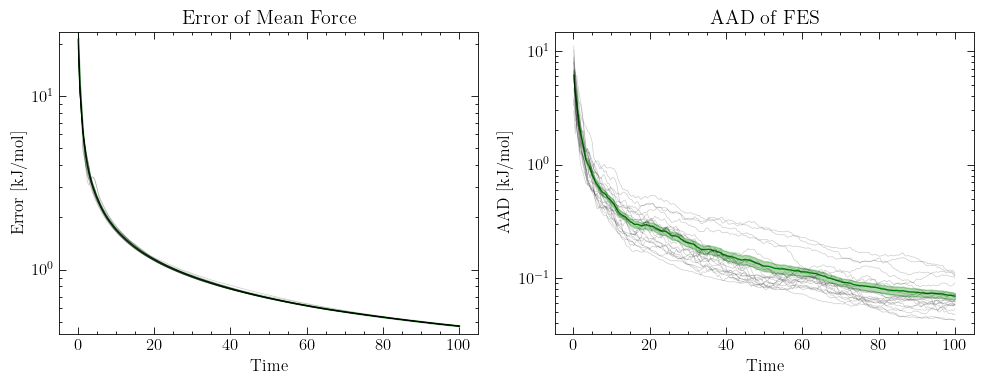

In [4]:
path_PRTR = path_notebook + "/_data_PRTR/"
n_surf = 3
total_campaigns = 21
time_budget = 100

# calculate and plot the average error progression
avr_prog = lib1.get_avr_error_prog(path_PRTR, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="PRTR", show_plot=True, return_avr_prog=True)
time_PRTR, ofe_mean_PRTR, ofe_ste_PRTR, aad_mean_PRTR, aad_ste_PRTR = avr_prog    

lib1.save_pkl([time_PRTR, ofe_mean_PRTR, ofe_ste_PRTR, aad_mean_PRTR, aad_ste_PRTR], path_notebook + f"/error_progressions/error_progression_PRTR_S{n_surf}.pkl")



#### Compare all methods

In [6]:
time_PRTR.shape

(250,)

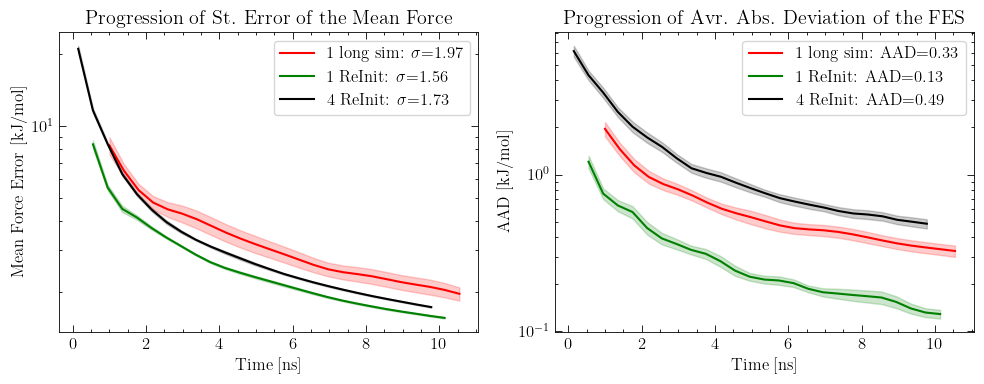

In [7]:
n_surf = 3
[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib1.load_pkl(path_notebook + f"/error_progressions/error_progression_long_S{n_surf}.pkl")
# [time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p] = lib1.load_pkl(path_notebook + f"/error_progressions/error_progression_x4_S{n_surf}.pkl"  )
[time_SRTR, ofe_mean_SRTR, ofe_ste_SRTR, aad_mean_SRTR, aad_ste_SRTR] = lib1.load_pkl(path_notebook + f"/error_progressions/error_progression_SRTR_S{n_surf}.pkl")
[time_PRTR, ofe_mean_PRTR, ofe_ste_PRTR, aad_mean_PRTR, aad_ste_PRTR] = lib1.load_pkl(path_notebook + f"/error_progressions/error_progression_PRTR_S{n_surf}.pkl")

[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = [time_l[:25], ofe_mean_l[:25], ofe_ste_l[:25], aad_mean_l[:25], aad_ste_l[:25]]
[time_SRTR, ofe_mean_SRTR, ofe_ste_SRTR, aad_mean_SRTR, aad_ste_SRTR] = [time_SRTR[:25], ofe_mean_SRTR[:25], ofe_ste_SRTR[:25], aad_mean_SRTR[:25], aad_ste_SRTR[:25]]
[time_PRTR, ofe_mean_PRTR, ofe_ste_PRTR, aad_mean_PRTR, aad_ste_PRTR] = [time_PRTR[:25], ofe_mean_PRTR[:25], ofe_ste_PRTR[:25], aad_mean_PRTR[:25], aad_ste_PRTR[:25]]


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)  #############################################################

plt.plot(time_l, ofe_mean_l, color="red", label=f"1 long sim: $\sigma$={ofe_mean_l[-1]:.2f}")
plt.fill_between(time_l, ofe_mean_l-ofe_ste_l, ofe_mean_l+ofe_ste_l, color="red", alpha=0.2)

# plt.plot(time_p, ofe_mean_p, color="blue", label=f"4 long sim: $\sigma$={ofe_mean_p[-1]:.2f}")
# plt.fill_between(time_p, ofe_mean_p-ofe_ste_p, ofe_mean_p+ofe_ste_p, color="blue", alpha=0.2)

plt.plot(time_SRTR, ofe_mean_SRTR, color="green", label=f"1 ReInit: $\sigma$={ofe_mean_SRTR[-1]:.2f}")
plt.fill_between(time_SRTR, ofe_mean_SRTR-ofe_ste_SRTR, ofe_mean_SRTR+ofe_ste_SRTR, color="green", alpha=0.2)

plt.plot(time_PRTR, ofe_mean_PRTR, color="black", label=f"4 ReInit: $\sigma$={ofe_mean_PRTR[-1]:.2f}")
plt.fill_between(time_PRTR, ofe_mean_PRTR-ofe_ste_PRTR, ofe_mean_PRTR+ofe_ste_PRTR, color="black", alpha=0.2)

plt.title("Progression of St. Error of the Mean Force"); plt.xlabel("Time [ns]"); plt.ylabel("Mean Force Error [kJ/mol]"); 
plt.yscale("log")
# plt.ylim(0.4, 4)
plt.legend()



plt.subplot(1,2,2) #############################################################

plt.plot(time_l, aad_mean_l, color="red", label=f"1 long sim: AAD={aad_mean_l[-1]:.2f}")
plt.fill_between(time_l, aad_mean_l-aad_ste_l, aad_mean_l+aad_ste_l, color="red", alpha=0.2)

# plt.plot(time_p, aad_mean_p, color="blue", label=f"4 long sim:  AAD={aad_mean_p[-1]:.2f}")
# plt.fill_between(time_p, aad_mean_p-aad_ste_p, aad_mean_p+aad_ste_p, color="blue", alpha=0.2)

plt.plot(time_SRTR, aad_mean_SRTR, color="green", label=f"1 ReInit: AAD={aad_mean_SRTR[-1]:.2f}")
plt.fill_between(time_SRTR, aad_mean_SRTR-aad_ste_SRTR, aad_mean_SRTR+aad_ste_SRTR, color="green", alpha=0.2)

plt.plot(time_PRTR, aad_mean_PRTR, color="black", label=f"4 ReInit: AAD={aad_mean_PRTR[-1]:.2f}")
plt.fill_between(time_PRTR, aad_mean_PRTR-aad_ste_PRTR, aad_mean_PRTR+aad_ste_PRTR, color="black", alpha=0.2)

plt.title("Progression of Avr. Abs. Deviation of the FES"); plt.xlabel("Time [ns]"); plt.ylabel("AAD [kJ/mol]"); 
plt.yscale("log")
# plt.ylim(0.05, 1)

# plt.xlim(0,10)

plt.legend()
plt.tight_layout(); plt.show()

In [14]:
# lib1.save_pkl([time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l], path_class + "/error_progressions/error_progression_long")
# lib1.save_pkl([time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p], path_class + "/error_progressions/error_progression_x4"  )
# lib1.save_pkl([time_SRTR, ofe_mean_SRTR, ofe_ste_SRTR, aad_mean_SRTR, aad_ste_SRTR], path_class + "/error_progressions/error_progression_SRTR")
# lib1.save_pkl([time_PRTR, ofe_mean_PRTR, ofe_ste_PRTR, aad_mean_PRTR, aad_ste_PRTR], path_class + "/error_progressions/error_progression_PRTR")

In [15]:
print(f"AAD Long = {aad_mean_l[-1]:.4f}")
print(f"AAD x4   = {aad_mean_p[-1]:.4f}")
print(f"AAD SRTR = {aad_mean_SRTR[-1]:.4f}")
print(f"AAD PRTR = {aad_mean_PRTR[-1]:.4f}")

AAD Long = 0.05910364007368896
AAD x4   = 0.11042079120012473
AAD SRTR = 0.05210359776865955
AAD PRTR = 0.12871617528864265
